# Part3 GAN

In [ ]:
!gdown --id 1O7m1010EJjLE5QxLZiM9Fpjs7Oj6e684

Permission denied: https://drive.google.com/uc?id=1O7m1010EJjLE5QxLZiM9Fpjs7Oj6e684
Maybe you need to change permission over 'Anyone with the link'?


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import os
import gdown
from zipfile import ZipFile

In [ ]:
#download data into created directory
os.makedirs("celeba_gan", exist_ok=True)

url = "https://drive.google.com/uc?id=1O7m1010EJjLE5QxLZiM9Fpjs7Oj6e684"
output = "celeba_gan/data.zip"
gdown.download(url, output, quiet=True)

Permission denied: https://drive.google.com/uc?id=1O7m1010EJjLE5QxLZiM9Fpjs7Oj6e684
Maybe you need to change permission over 'Anyone with the link'?


In [ ]:
with ZipFile("celeba_gan/img_align_celeba.zip", "r") as zipobj:
  zipobj.extractall("celeba_gan")

In [ ]:
#dataset
dataset = keras.preprocessing.image_dataset_from_directory("celeba_gan", label_mode=None, image_size=(64, 64), batch_size=32)
dataset = dataset.map(lambda x: x / 255.0)

Found 202599 files belonging to 1 classes.


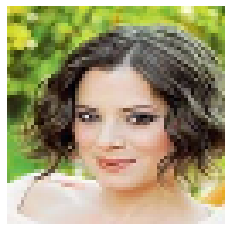

In [ ]:
for x in dataset:
    plt.axis("off")
    plt.imshow(x.numpy()[0])
    break

In [ ]:
def make_discriminator():
  model = keras.Sequential([
                    keras.Input(shape=(64, 64, 3)),
                    layers.Conv2D(64, kernel_size=4, strides=2, padding="same"),
                    layers.LeakyReLU(alpha=0.2),
                    #32x32x64

                    layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
                    layers.LeakyReLU(alpha=0.2),
                    #16x16x128

                    layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
                    layers.LeakyReLU(alpha=0.2),
                    #8x8x128

                    layers.Flatten(),
                    layers.Dropout(0.2),
                    layers.Dense(1, activation="sigmoid")])
  return model

In [ ]:
def make_generator(latent_dim):
  model = keras.Sequential([
                            keras.Input(shape=(latent_dim,)),
                            layers.Dense(8 * 8 * 128),
                            layers.Reshape((8, 8, 128)),
                            #8x8x128
                            
                            layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding="same"),
                            layers.BatchNormalization(),
                            layers.LeakyReLU(alpha=0.2),
                            #16x16x128

                            layers.Conv2DTranspose(256, kernel_size=4, strides=2, padding="same"),
                            layers.BatchNormalization(),
                            layers.LeakyReLU(alpha=0.2),
                            #32x32x256
                            
                            layers.Conv2DTranspose(512, kernel_size=4, strides=2, padding="same"),
                            layers.BatchNormalization(),
                            layers.LeakyReLU(alpha=0.2),
                            #64x64x512

                            layers.Conv2D(3, kernel_size=5, padding="same", activation="sigmoid")
                            #64x64x3
                            ])
  return model

In [ ]:
class GAN(keras.Model):
  def __init__(self, discriminator, generator, latent_dim):
    super(GAN, self).__init__()
    self.discriminator = discriminator
    self.generator = generator
    self.latent_dim = latent_dim
  
  def compile(self, d_optimizer, g_optimizer, loss_fn):
    super(GAN, self).compile()
    #optimizer
    self.d_optimizer = d_optimizer
    self.g_optimizer = g_optimizer

    #loss function
    self.loss_fn = loss_fn
    
    #accuracy
    self.d_loss_metric = keras.metrics.Mean(name="d_loss")
    self.g_loss_metric = keras.metrics.Mean(name="g_loss")

  @property
  def metrics(self):
    return [self.d_loss_metric, self.g_loss_metric]


  def train_step(self, real_images):
    """ function for training generator and discriminator
    real_images(tensor): images 
    """
    #random points in the latent space
    batch_size = tf.shape(real_images)[0]
    random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

    #1.train discriminator
    #decode random_latent_vectors to fake images
    generated_images = self.generator(random_latent_vectors)

    #combine generated images with real images
    combined_images = tf.concat([generated_images, real_images], axis=0)

    #labels for discriminating real(0) and fake(1) images
    labels = tf.concat([tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0)

    #add random noise to each label (important trick!)
    labels += 0.05 * tf.random.uniform(tf.shape(labels))

    with tf.GradientTape() as tape:
      predictions = self.discriminator(combined_images)
      d_loss = self.loss_fn(labels, predictions)
    #backpropagation for discriminator
    grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
    self.d_optimizer.apply_gradients(zip(grads, self.discriminator.trainable_weights))


    #2.train generator (not update the weights of the discriminator)
    #random points in the latent space
    random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
    #misleading labels
    misleading_labels = tf.zeros((batch_size, 1))

    with tf.GradientTape() as tape:
      predictions = self.discriminator(self.generator(random_latent_vectors))
      g_loss = self.loss_fn(misleading_labels, predictions)
    #backpropagation for generator
    grads = tape.gradient(g_loss, self.generator.trainable_weights)
    self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

    # Update metrics
    self.d_loss_metric.update_state(d_loss)
    self.g_loss_metric.update_state(g_loss)
    return {"d_loss": self.d_loss_metric.result(), "g_loss": self.g_loss_metric.result()}

In [ ]:
class GANMonitor(keras.callbacks.Callback):
    def __init__(self, num_img=10, latent_dim=128):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
        generated_images = self.model.generator(random_latent_vectors)
        #generated_images *= 255
        generated_images = generated_images.numpy()

        plt.figure(figsize=(8,3))
        for i in range(generated_images.shape[0]):
          plt.subplot(2, 5, i+1)
          plt.imshow(generated_images[i])
          plt.axis('off')
        plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
        plt.show()

        for i in range(self.num_img):
            img = keras.preprocessing.image.array_to_img(generated_images[i])
            img.save("generated_img_%03d_%d.png" % (epoch, i))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

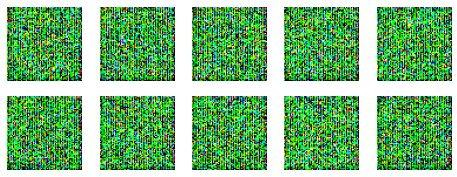

In [ ]:
# random_latent_vectors = tf.random.normal(shape=(10, 128))
# generator = make_generator(128)

# images = generator(random_latent_vectors)
# images *= 255
# images = images.numpy()
# permutate = [2,1,0]
# images = images[:, :, :, permutate]


# plt.figure(figsize=(8,3))
# for i in range(images.shape[0]):
#   plt.subplot(2, 5, i+1)
#   plt.imshow(images[i])
#   plt.axis('off')
# plt.show()

In [ ]:
#parameters
epochs = 25 
latent_dim = 128

discriminator = make_discriminator()
generator = make_generator(latent_dim)
d_optimizer=keras.optimizers.Adam(learning_rate=1e-4)
g_optimizer=keras.optimizers.Adam(learning_rate=1e-4)
loss_fn=keras.losses.BinaryCrossentropy()

#model
gan = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)
gan.compile(d_optimizer=d_optimizer, g_optimizer=g_optimizer, loss_fn=loss_fn)

#run
gan.fit(dataset, epochs=epochs, callbacks=[GANMonitor(num_img=10, latent_dim=latent_dim)])

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
gan.get_weights()

In [ ]:
from keras.models import load_model
gan.save_weights("/content/drive/MyDrive/myGAN_h5_model.h5")

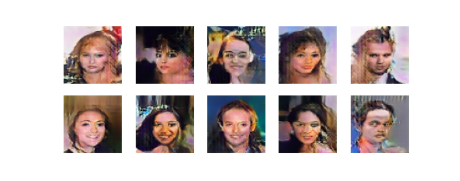

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt 
import matplotlib.image as mgimg
from matplotlib import animation

fig = plt.figure(figsize=(8,4))
plt.axis('off')

# initiate an empty  list of "plotted" images 
myimages = []

#loops through available png:s
for p in range(0, 24):
    ## Read in picture
    file_name = "/content/image_at_epoch_%04d.png" %p 
    img = mgimg.imread(file_name)
    imgplot = plt.imshow(img)

    # append AxesImage object to the list
    myimages.append([imgplot])

##create an instance of animation
my_anim = animation.ArtistAnimation(fig, myimages, interval=300, blit=True, repeat_delay=1000)

## NB: The 'save' method here belongs to the object you created above
my_anim.save("animation.mp4")

##Showtime!
plt.show()

In [ ]:
from matplotlib import rc
rc('animation', html='jshtml')

In [ ]:
my_anim

Output hidden; open in https://colab.research.google.com to view.